In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/plant_seedlings_classification"

In [5]:
print(torch.cuda.is_available())

print(torch.backends.cudnn.enabled)

os.listdir(PATH)

True
True


['valid', 'test', 'models', 'sample_submission.csv', 'train', 'tmp']

In [ ]:
dirs = os.listdir(f'{PATH}/train')
dirs

In [ ]:
files = os.listdir(f'{PATH}/train/Sugar beet')[:5]

In [ ]:
img = plt.imread(f'{PATH}/train/Sugar beet/{files[0]}')

plt.imshow(img)

In [ ]:
img.shape

In [ ]:
class_to_count = { classification : len(os.listdir(f'{PATH}/train/{classification}')) for classification in dirs }
class_to_count

In [ ]:
def create_valid_from_train_dir(path, train_dir='train', val_dir='valid'):
    sets_top_level = os.listdir(path)
    if sets_top_level.count(val_dir):
        print(f'Validation directory - {val_dir} - already exists. exiting function')
        return
    
    train_path = f'{path}/{train_dir}'
    valid_path = f'{path}/{val_dir}'
    os.mkdir(valid_path)
    
    classes = os.listdir(f'{path}/{train_dir}')
    class_to_fns = { cls : os.listdir(f'{train_path}/{cls}') for cls in classes }
    class_to_count = { cls : len(fns) for (cls, fns) in class_to_fns.items() }
    class_to_cv_idxs = { cls : get_cv_idxs(cnt).tolist() for (cls, cnt) in class_to_count.items() }
    
    for (cls, cv_idxs) in class_to_cv_idxs.items():
        train_class_path = f'{train_path}/{cls}'
        valid_class_path = f'{valid_path}/{cls}'
        
        os.mkdir(valid_class_path)
        
        fns = class_to_fns[cls]
        fns_to_move = [fns[i] for i in cv_idxs]
        
        for fn in fns_to_move:
            shutil.move(f'{train_class_path}/{fn}', f'{valid_class_path}/{fn}')
        print(f'moved {len(fns_to_move)} out of {len(fns)} files for class: {cls}')

create_valid_from_train_dir(PATH)

In [ ]:
arch=resnet34
sz = 224

data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

## Initial, naive model

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

## Choosing a learning rate

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

10^-1 (or maybe 10^(-1.5) = 0.0316 )looks good!

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.0316, 5)

## Data Augmentation

In [6]:
sz=299
bs=32
arch=resnet50
tfms = tfms_from_model(arch, sz, aug_tfms=[RandomDihedral(), RandomLighting(0.05, 0.05)], max_zoom=1.1)

In [7]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

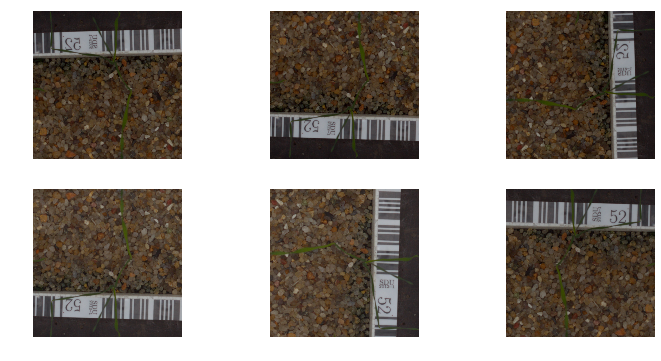

In [8]:
ims = np.stack([get_augs() for i in range(6)])

plots(ims, rows=2)

In [30]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, test_name='test')

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [10]:
lrf=learn.lr_find()

 86%|████████▌ | 102/119 [00:01<00:02,  6.23it/s, loss=4.57]


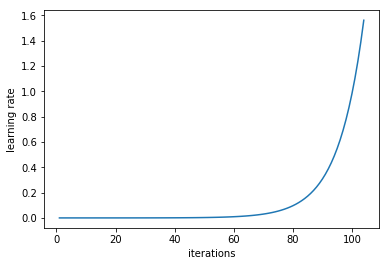

In [11]:
learn.sched.plot_lr()

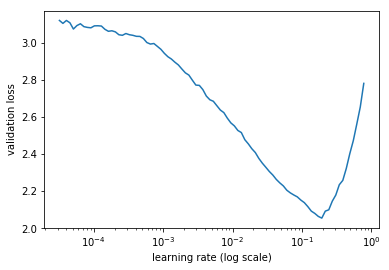

In [12]:
learn.sched.plot()

In [13]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                  
    0      1.073797   0.629864   0.799366  



[array([0.62986]), 0.7993664204004322]

In [14]:
learn.precompute=False

In [15]:
learn.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.735765   0.492062   0.837381  
    1      0.696447   0.445388   0.858501                    
    2      0.640904   0.416156   0.86906                     



[array([0.41616]), 0.8690601897592152]

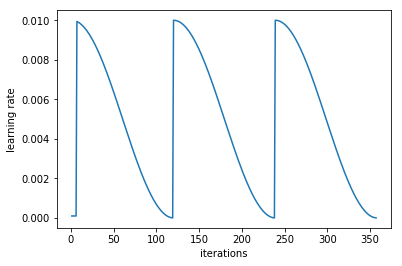

In [16]:
learn.sched.plot_lr()

In [17]:
learn.unfreeze()

In [18]:
lrf=learn.lr_find()

 85%|████████▍ | 101/119 [00:58<00:09,  1.82it/s, loss=3.56]

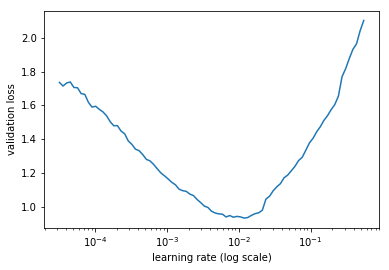

In [19]:
learn.sched.plot()

In [20]:
lr=np.array([0.0000625,0.00025,0.001])

In [21]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.625084   0.346064   0.883844  
    1      0.408227   0.229478   0.931362                    
    2      0.349231   0.213195   0.93453                     
    3      0.294983   0.186607   0.937698                    
    4      0.259882   0.177381   0.940866                    
    5      0.250337   0.167982   0.94509                     
    6      0.229742   0.170011   0.946146                    
    7      0.226088   0.153387   0.952482                    
    8      0.196101   0.149887   0.953537                    
    9      0.1845     0.132455   0.957761                    
    10     0.167106   0.135882   0.956705                    
    11     0.164353   0.129865   0.960929                    
    12     0.156198   0.131135   0.956705                    
    13     0.159704   0.125482   0.963041                    
    14     0.145583   0.129172   0.961985                    


[array([0.12917]), 0.9619852164730729]

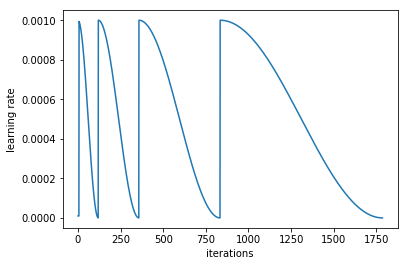

In [22]:
learn.sched.plot_lr()

In [25]:
learn.fit(lr, 1, cycle_len=10)

epoch      trn_loss   val_loss   accuracy                    
    0      0.142756   0.116448   0.969377  
    1      0.138012   0.111862   0.969377                    
    2      0.115424   0.107736   0.968321                    
    3      0.122338   0.099471   0.972545                    
    4      0.105062   0.104064   0.969377                    
    5      0.110259   0.104595   0.970433                    
    6      0.107514   0.097925   0.968321                    
    7      0.097271   0.097515   0.971489                     
    8      0.093902   0.100647   0.969377                     
    9      0.092008   0.097917   0.969377                     


[array([0.09792]), 0.9693769799366421]

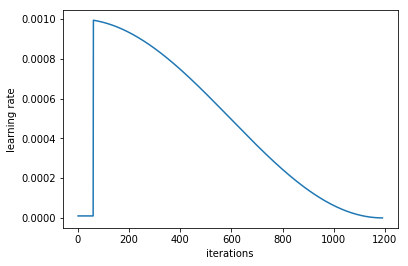

In [26]:
learn.sched.plot_lr()

In [27]:
learn.save('299_all_resnet50_bs32_bnfreezefalse_ps05')


## Create Submission

In [31]:
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [32]:
data.test_ds.fnames

['test/24d78df74.png',
 'test/b828443ff.png',
 'test/33448fe39.png',
 'test/55920f07f.png',
 'test/ff65bc002.png',
 'test/82b5f4d33.png',
 'test/1b6a6494d.png',
 'test/bdde957ec.png',
 'test/03a2ee656.png',
 'test/8301b0547.png',
 'test/1bf9b94a6.png',
 'test/063363305.png',
 'test/223e4af09.png',
 'test/4bbf1f6ea.png',
 'test/0a64e3e6c.png',
 'test/da231c97f.png',
 'test/c5e88cd42.png',
 'test/a74bf916d.png',
 'test/a55d26a4c.png',
 'test/20817c846.png',
 'test/c75a82234.png',
 'test/752101fdf.png',
 'test/3a909ead8.png',
 'test/466bb6d3b.png',
 'test/eef131644.png',
 'test/599c82eea.png',
 'test/1758a1baf.png',
 'test/cadab6616.png',
 'test/8170d33c1.png',
 'test/1f290e016.png',
 'test/756dd5070.png',
 'test/974959ec1.png',
 'test/958bb9e96.png',
 'test/ab35453cb.png',
 'test/56112b92c.png',
 'test/fe29629fb.png',
 'test/a8da9c08d.png',
 'test/f66ae4070.png',
 'test/1d321253f.png',
 'test/03e322a29.png',
 'test/288564c76.png',
 'test/0885e7690.png',
 'test/686dc7ec8.png',
 'test/30ad

In [38]:
learn.set_data(data)

In [39]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)


In [59]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [60]:
df['species'] = df.idxmax(axis=1); df.head()

,Black-grass,Charlock,Cleavers,Common Chickweed,Common wheat,Fat Hen,Loose Silky-bent,Maize,Scentless Mayweed,Shepherds Purse,Small-flowered Cranesbill,Sugar beet,species
0,4.395721e-06,7.547008e-08,0.000013,9.980531e-01,0.000004,0.000228,6.932399e-06,0.000002,5.779622e-05,2.472650e-06,6.051823e-07,0.001627,Common Chickweed
1,2.026330e-06,1.155098e-04,0.000015,6.042356e-06,0.000009,0.000039,2.165015e-07,0.999757,2.165222e-07,3.083550e-06,1.955450e-05,0.000033,Maize
2,6.664817e-02,1.774698e-07,0.000005,8.595850e-06,0.000024,0.000004,9.332787e-01,0.000001,2.344010e-05,1.182209e-06,4.145812e-06,0.000001,Loose Silky-bent
3,1.592812e-05,3.891949e-05,0.000011,9.999390e-06,0.000028,0.000488,2.679201e-07,0.999346,3.239415e-08,3.186074e-07,2.506844e-05,0.000037,Maize
4,6.551873e-08,9.999620e-01,0.000003,6.715146e-08,0.000010,0.000019,6.871757e-09,0.000003,2.398253e-08,6.652577e-07,1.001549e-06,0.000002,Charlock


In [61]:
df = df[['species']]

In [62]:
df.insert(0, 'file', [o[5:] for o in data.test_ds.fnames])

df.head()

,file,species
0,24d78df74.png,Common Chickweed
1,b828443ff.png,Maize
2,33448fe39.png,Loose Silky-bent
3,55920f07f.png,Maize
4,ff65bc002.png,Charlock


In [52]:
df

,Black-grass,Charlock,Cleavers,Common Chickweed,Common wheat,Fat Hen,Loose Silky-bent,Maize,Scentless Mayweed,Shepherds Purse,Small-flowered Cranesbill,Sugar beet
0,4.395721e-06,7.547008e-08,1.292065e-05,9.980531e-01,4.191871e-06,2.281154e-04,6.932399e-06,1.924736e-06,5.779622e-05,2.472650e-06,6.051823e-07,1.627469e-03
1,2.026330e-06,1.155098e-04,1.466402e-05,6.042356e-06,9.366251e-06,3.927480e-05,2.165015e-07,9.997572e-01,2.165222e-07,3.083550e-06,1.955450e-05,3.258278e-05
2,6.664817e-02,1.774698e-07,5.219568e-06,8.595850e-06,2.380783e-05,3.848970e-06,9.332787e-01,1.407155e-06,2.344010e-05,1.182209e-06,4.145812e-06,1.276771e-06
3,1.592812e-05,3.891949e-05,1.060564e-05,9.999390e-06,2.807353e-05,4.880891e-04,2.679201e-07,9.993457e-01,3.239415e-08,3.186074e-07,2.506844e-05,3.704385e-05
4,6.551873e-08,9.999620e-01,2.930974e-06,6.715146e-08,9.828046e-06,1.889326e-05,6.871757e-09,3.056632e-06,2.398253e-08,6.652577e-07,1.001549e-06,1.653127e-06
5,7.873841e-06,1.190237e-03,2.974163e-03,1.876139e-03,4.847545e-06,3.831646e-04,4.168903e-05,9.421027e-06,5.361391e-04,9.913718e-01,1.596270e-03,8.334047e-06
6,2.995198e-06,3.464662e-06,1.033574e-03,1.381926e-05,3.301190e-04,8.724829e-05,6.675667e-07,2.559448e-06,1.616357e-05,7.308260e-07,7.276518e-09,9.985086e-01
7,1.070939e-06,1.321825e-05,4.831338e-05,8.544141e-05,2.850853e-06,8.785703e-06,1.244635e-05,6.842298e-07,9.898225e-01,9.990762e-03,9.999771e-06,3.733102e-06
8,6.503366e-06,1.401200e-04,5.136287e-05,5.180771e-05,1.996754e-07,3.327970e-05,4.766583e-06,1.723973e-06,3.453671e-07,8.392214e-05,9.996260e-01,7.325586e-08
9,1.015945e-08,9.999935e-01,2.233262e-06,1.938286e-09,1.511438e-06,3.619218e-08,2.293610e-09,1.925393e-06,4.363737e-08,1.906788e-07,8.559599e-07,2.361024e-07


In [51]:
dfm.insert(0, 'file', [o[5:] for o in data.test_ds.fnames])

dfm.head()

AttributeError: 'Series' object has no attribute 'insert'

In [63]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)